In [1]:
import endomill
import yaml


In [2]:
parameter_packs = [
    {
        "MILL_FITNESS_ADVANTAGE": fitness_advantage,
        "MILL_REPLICATE": replicate,
    }
    for replicate in range(10)
    for fitness_advantage in [0.0, 1.0, 1.0]
]

for i, pp in enumerate(parameter_packs):
    with open(
        f"gene-selection-inference-parameterization-{i}.yaml", "w"
    ) as file:
        yaml.safe_dump(pp, file)
# endomill.instantiate_over(parameter_packs=parameter_packs)


# Papermill Parameters


In [3]:
MILL_FITNESS_ADVANTAGE: float
MILL_REPLICATE: int


In [4]:
# Parameters
MILL_FITNESS_ADVANTAGE = 0.0
MILL_REPLICATE = 1


In [5]:
import copy
import random

import alifedata_phyloinformatics_convert as apc
from deap import algorithms as deap_algorithms
from deap import base as deap_base
from deap import creator as deap_creator
from deap import tools as deap_tools
from hstrat import hstrat
from keyname import keyname as kn
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
from teeplot import teeplot as tp
from tqdm import tqdm

import pylib


In [6]:
random.seed(MILL_REPLICATE)


# Parameters


In [7]:
HSTRAT_RESOLUTION = 1000
HSTRAT_DIFFERENTIA_WIDTH = 64

TOURNAMENT_SIZE = 2

NGEN = 200

POPULATION_SIZE = 400


# Setup


In [8]:
deap_creator.create("FitnessMax", deap_base.Fitness, weights=(1.0,))
deap_creator.create("Individual", list, fitness=deap_creator.FitnessMax)

toolbox = deap_base.Toolbox()

toolbox.register(
    "individual",
    lambda *args, **kwargs: deap_creator.Individual([0.0]),
    deap_creator.Individual,
    n=1,
)
toolbox.register("population", deap_tools.initRepeat, list, toolbox.individual)


def evalOneMax(individual):
    return (individual[0] + random.random(),)


toolbox.register("evaluate", evalOneMax)
# hack to ensure gene annotation remains associated with gene
toolbox.register("mate", lambda x, y: random.choice([(x, y), (y, x)]))
toolbox.register("mutate", lambda x: tuple(x))
toolbox.register("select", deap_tools.selTournament, tournsize=TOURNAMENT_SIZE)

# Decorate the variation operators
toolbox.decorate("mate", pylib.deap.hstrat_mate_decorator)


# Evolve


In [9]:
# Create the population and populate the history
population = toolbox.population(n=POPULATION_SIZE)

species_ancestor = hstrat.HereditaryStratigraphicColumn(
    stratum_retention_policy=hstrat.nominal_resolution_algo.Policy(),
    stratum_differentia_bit_width=HSTRAT_DIFFERENTIA_WIDTH,
)
for member in population:
    member.species_annotation = species_ancestor.CloneDescendant()
    member.gene_annotation = hstrat.HereditaryStratigraphicColumn(
        stratum_retention_policy=hstrat.perfect_resolution_algo.Policy(),
        stratum_differentia_bit_width=HSTRAT_DIFFERENTIA_WIDTH,
        initial_stratum_annotation=0,
    ).CloneDescendant(0)


# Do the evolution, the decorators will take care of updating the
# history
prevalences = []
for gen in tqdm(range(NGEN)):
    prevalences.append(sum(1 for x in population if x[0] > 0))

    offspring = deap_algorithms.varAnd(
        population, toolbox, cxpb=1.0, mutpb=0.0
    )
    fits = toolbox.map(toolbox.evaluate, offspring)
    for fit, ind in zip(fits, offspring):
        ind.fitness.values = fit
    population = toolbox.select(offspring, k=len(population))
    population = [copy.deepcopy(ind) for ind in population]

    if gen >= NGEN // 4:
        if prevalences[-1] == 0:
            population[0][0] = MILL_FITNESS_ADVANTAGE



  0%|                                                                  | 0/200 [00:00<?, ?it/s]

  0%|▎                                                         | 1/200 [00:00<03:13,  1.03it/s]

  1%|▌                                                         | 2/200 [00:02<03:21,  1.02s/it]

  2%|▊                                                         | 3/200 [00:02<03:07,  1.05it/s]

  2%|█▏                                                        | 4/200 [00:04<03:18,  1.01s/it]

  2%|█▍                                                        | 5/200 [00:04<03:08,  1.03it/s]

  3%|█▋                                                        | 6/200 [00:05<03:07,  1.04it/s]

  4%|██                                                        | 7/200 [00:06<03:07,  1.03it/s]

  4%|██▎                                                       | 8/200 [00:08<03:22,  1.06s/it]

  4%|██▌                                                       | 9/200 [00:09<03:34,  1.12s/it]

  5%|██▊                                                      | 10/200 [00:10<03:42,  1.17s/it]

  6%|███▏                                                     | 11/200 [00:11<03:34,  1.13s/it]

  6%|███▍                                                     | 12/200 [00:12<03:42,  1.18s/it]

  6%|███▋                                                     | 13/200 [00:14<03:52,  1.24s/it]

  7%|███▉                                                     | 14/200 [00:15<03:57,  1.28s/it]

  8%|████▎                                                    | 15/200 [00:17<04:03,  1.32s/it]

  8%|████▌                                                    | 16/200 [00:18<03:54,  1.28s/it]

  8%|████▊                                                    | 17/200 [00:19<04:02,  1.32s/it]

  9%|█████▏                                                   | 18/200 [00:21<04:08,  1.37s/it]

 10%|█████▍                                                   | 19/200 [00:22<04:14,  1.41s/it]

 10%|█████▋                                                   | 20/200 [00:23<04:06,  1.37s/it]

 10%|█████▉                                                   | 21/200 [00:25<04:15,  1.43s/it]

 11%|██████▎                                                  | 22/200 [00:27<04:22,  1.47s/it]

 12%|██████▌                                                  | 23/200 [00:28<04:12,  1.42s/it]

 12%|██████▊                                                  | 24/200 [00:29<03:56,  1.34s/it]

 12%|███████▏                                                 | 25/200 [00:30<03:50,  1.32s/it]

 13%|███████▍                                                 | 26/200 [00:32<03:45,  1.30s/it]

 14%|███████▋                                                 | 27/200 [00:33<04:06,  1.42s/it]

 14%|███████▉                                                 | 28/200 [00:35<04:20,  1.51s/it]

 14%|████████▎                                                | 29/200 [00:37<04:32,  1.59s/it]

 15%|████████▌                                                | 30/200 [00:39<04:41,  1.66s/it]

 16%|████████▊                                                | 31/200 [00:40<04:46,  1.69s/it]

 16%|█████████                                                | 32/200 [00:42<04:49,  1.72s/it]

 16%|█████████▍                                               | 33/200 [00:44<04:39,  1.67s/it]

 17%|█████████▋                                               | 34/200 [00:46<04:46,  1.73s/it]

 18%|█████████▉                                               | 35/200 [00:47<04:51,  1.77s/it]

 18%|██████████▎                                              | 36/200 [00:49<04:58,  1.82s/it]

 18%|██████████▌                                              | 37/200 [00:51<05:04,  1.87s/it]

 19%|██████████▊                                              | 38/200 [00:53<05:02,  1.87s/it]

 20%|███████████                                              | 39/200 [00:55<05:02,  1.88s/it]

 20%|███████████▍                                             | 40/200 [00:57<05:09,  1.93s/it]

 20%|███████████▋                                             | 41/200 [00:59<05:11,  1.96s/it]

 21%|███████████▉                                             | 42/200 [01:01<05:10,  1.97s/it]

 22%|████████████▎                                            | 43/200 [01:03<05:11,  1.99s/it]

 22%|████████████▌                                            | 44/200 [01:05<05:14,  2.02s/it]

 22%|████████████▊                                            | 45/200 [01:07<05:17,  2.05s/it]

 23%|█████████████                                            | 46/200 [01:09<05:10,  2.02s/it]

 24%|█████████████▍                                           | 47/200 [01:11<04:28,  1.75s/it]

 24%|█████████████▋                                           | 48/200 [01:12<04:00,  1.58s/it]

 24%|█████████████▉                                           | 49/200 [01:13<03:45,  1.49s/it]

 25%|██████████████▎                                          | 50/200 [01:14<03:29,  1.40s/it]

 26%|██████████████▌                                          | 51/200 [01:16<04:04,  1.64s/it]

 26%|██████████████▊                                          | 52/200 [01:18<03:55,  1.59s/it]

 26%|███████████████                                          | 53/200 [01:19<03:44,  1.53s/it]

 27%|███████████████▍                                         | 54/200 [01:21<03:30,  1.44s/it]

 28%|███████████████▋                                         | 55/200 [01:22<03:23,  1.40s/it]

 28%|███████████████▉                                         | 56/200 [01:23<03:20,  1.40s/it]

 28%|████████████████▏                                        | 57/200 [01:25<03:17,  1.38s/it]

 29%|████████████████▌                                        | 58/200 [01:26<03:13,  1.36s/it]

 30%|████████████████▊                                        | 59/200 [01:27<03:10,  1.35s/it]

 30%|█████████████████                                        | 60/200 [01:29<03:14,  1.39s/it]

 30%|█████████████████▍                                       | 61/200 [01:30<03:12,  1.38s/it]

 31%|█████████████████▋                                       | 62/200 [01:31<03:14,  1.41s/it]

 32%|█████████████████▉                                       | 63/200 [01:33<03:16,  1.44s/it]

 32%|██████████████████▏                                      | 64/200 [01:34<03:11,  1.41s/it]

 32%|██████████████████▌                                      | 65/200 [01:36<03:11,  1.42s/it]

 33%|██████████████████▊                                      | 66/200 [01:37<03:11,  1.43s/it]

 34%|███████████████████                                      | 67/200 [01:39<03:11,  1.44s/it]

 34%|███████████████████▍                                     | 68/200 [01:40<03:13,  1.46s/it]

 34%|███████████████████▋                                     | 69/200 [01:42<03:09,  1.45s/it]

 35%|███████████████████▉                                     | 70/200 [01:43<03:10,  1.46s/it]

 36%|████████████████████▏                                    | 71/200 [01:45<03:10,  1.48s/it]

 36%|████████████████████▌                                    | 72/200 [01:46<03:10,  1.49s/it]

 36%|████████████████████▊                                    | 73/200 [01:48<03:09,  1.49s/it]

 37%|█████████████████████                                    | 74/200 [01:50<03:32,  1.69s/it]

 38%|█████████████████████▍                                   | 75/200 [01:52<03:56,  1.89s/it]

 38%|█████████████████████▋                                   | 76/200 [01:54<03:58,  1.93s/it]

 38%|█████████████████████▉                                   | 77/200 [01:56<03:51,  1.88s/it]

 39%|██████████████████████▏                                  | 78/200 [01:58<03:43,  1.83s/it]

 40%|██████████████████████▌                                  | 79/200 [02:00<03:53,  1.93s/it]

 40%|██████████████████████▊                                  | 80/200 [02:02<04:01,  2.01s/it]

 40%|███████████████████████                                  | 81/200 [02:04<03:51,  1.94s/it]

 41%|███████████████████████▎                                 | 82/200 [02:06<03:41,  1.88s/it]

 42%|███████████████████████▋                                 | 83/200 [02:08<03:42,  1.90s/it]

 42%|███████████████████████▉                                 | 84/200 [02:09<03:34,  1.85s/it]

 42%|████████████████████████▏                                | 85/200 [02:11<03:47,  1.97s/it]

 43%|████████████████████████▌                                | 86/200 [02:14<04:04,  2.14s/it]

 44%|████████████████████████▊                                | 87/200 [02:17<04:33,  2.42s/it]

 44%|█████████████████████████                                | 88/200 [02:20<04:53,  2.62s/it]

 44%|█████████████████████████▎                               | 89/200 [02:24<05:17,  2.86s/it]

 45%|█████████████████████████▋                               | 90/200 [02:27<05:22,  2.93s/it]

 46%|█████████████████████████▉                               | 91/200 [02:30<05:24,  2.98s/it]

 46%|██████████████████████████▏                              | 92/200 [02:33<05:26,  3.02s/it]

 46%|██████████████████████████▌                              | 93/200 [02:36<05:37,  3.15s/it]

 47%|██████████████████████████▊                              | 94/200 [02:40<05:35,  3.17s/it]

 48%|███████████████████████████                              | 95/200 [02:43<05:34,  3.19s/it]

 48%|███████████████████████████▎                             | 96/200 [02:46<05:31,  3.19s/it]

 48%|███████████████████████████▋                             | 97/200 [02:50<05:39,  3.29s/it]

 49%|███████████████████████████▉                             | 98/200 [02:53<05:36,  3.29s/it]

 50%|████████████████████████████▏                            | 99/200 [02:56<05:32,  3.29s/it]

 50%|████████████████████████████                            | 100/200 [02:59<05:30,  3.30s/it]

 50%|████████████████████████████▎                           | 101/200 [03:03<05:29,  3.32s/it]

 51%|████████████████████████████▌                           | 102/200 [03:06<05:27,  3.34s/it]

 52%|████████████████████████████▊                           | 103/200 [03:09<05:20,  3.30s/it]

 52%|█████████████████████████████                           | 104/200 [03:11<04:39,  2.91s/it]

 52%|█████████████████████████████▍                          | 105/200 [03:14<04:14,  2.67s/it]

 53%|█████████████████████████████▋                          | 106/200 [03:15<03:49,  2.45s/it]

 54%|█████████████████████████████▉                          | 107/200 [03:17<03:32,  2.29s/it]

 54%|██████████████████████████████▏                         | 108/200 [03:19<03:18,  2.16s/it]

 55%|██████████████████████████████▌                         | 109/200 [03:21<03:16,  2.16s/it]

 55%|██████████████████████████████▊                         | 110/200 [03:23<03:08,  2.09s/it]

 56%|███████████████████████████████                         | 111/200 [03:25<03:01,  2.04s/it]

 56%|███████████████████████████████▎                        | 112/200 [03:27<02:57,  2.02s/it]

 56%|███████████████████████████████▋                        | 113/200 [03:29<03:01,  2.09s/it]

 57%|███████████████████████████████▉                        | 114/200 [03:31<02:57,  2.07s/it]

 57%|████████████████████████████████▏                       | 115/200 [03:34<02:55,  2.06s/it]

 58%|████████████████████████████████▍                       | 116/200 [03:36<03:04,  2.19s/it]

 58%|████████████████████████████████▊                       | 117/200 [03:39<03:23,  2.45s/it]

 59%|█████████████████████████████████                       | 118/200 [03:43<03:46,  2.76s/it]

 60%|█████████████████████████████████▎                      | 119/200 [03:46<04:08,  3.07s/it]

 60%|█████████████████████████████████▌                      | 120/200 [03:50<04:30,  3.38s/it]

 60%|█████████████████████████████████▉                      | 121/200 [03:54<04:38,  3.52s/it]

 61%|██████████████████████████████████▏                     | 122/200 [03:58<04:42,  3.62s/it]

 62%|██████████████████████████████████▍                     | 123/200 [04:02<04:46,  3.72s/it]

 62%|██████████████████████████████████▋                     | 124/200 [04:06<04:42,  3.71s/it]

 62%|███████████████████████████████████                     | 125/200 [04:09<04:23,  3.51s/it]

 63%|███████████████████████████████████▎                    | 126/200 [04:11<03:49,  3.10s/it]

 64%|███████████████████████████████████▌                    | 127/200 [04:15<04:00,  3.29s/it]

 64%|███████████████████████████████████▊                    | 128/200 [04:18<03:47,  3.15s/it]

 64%|████████████████████████████████████                    | 129/200 [04:20<03:21,  2.84s/it]

 65%|████████████████████████████████████▍                   | 130/200 [04:22<03:08,  2.70s/it]

 66%|████████████████████████████████████▋                   | 131/200 [04:24<02:55,  2.54s/it]

 66%|████████████████████████████████████▉                   | 132/200 [04:27<02:50,  2.51s/it]

 66%|█████████████████████████████████████▏                  | 133/200 [04:29<02:42,  2.43s/it]

 67%|█████████████████████████████████████▌                  | 134/200 [04:31<02:35,  2.36s/it]

 68%|█████████████████████████████████████▊                  | 135/200 [04:34<02:35,  2.39s/it]

 68%|██████████████████████████████████████                  | 136/200 [04:36<02:29,  2.34s/it]

 68%|██████████████████████████████████████▎                 | 137/200 [04:38<02:26,  2.33s/it]

 69%|██████████████████████████████████████▋                 | 138/200 [04:41<02:28,  2.39s/it]

 70%|██████████████████████████████████████▉                 | 139/200 [04:43<02:24,  2.37s/it]

 70%|███████████████████████████████████████▏                | 140/200 [04:45<02:25,  2.42s/it]

 70%|███████████████████████████████████████▍                | 141/200 [04:48<02:22,  2.41s/it]

 71%|███████████████████████████████████████▊                | 142/200 [04:51<02:28,  2.56s/it]

 72%|████████████████████████████████████████                | 143/200 [04:55<02:55,  3.07s/it]

 72%|████████████████████████████████████████▎               | 144/200 [04:59<03:14,  3.48s/it]

 72%|████████████████████████████████████████▌               | 145/200 [05:04<03:30,  3.83s/it]

 73%|████████████████████████████████████████▉               | 146/200 [05:09<03:35,  4.00s/it]

 74%|█████████████████████████████████████████▏              | 147/200 [05:13<03:43,  4.22s/it]

 74%|█████████████████████████████████████████▍              | 148/200 [05:18<03:42,  4.28s/it]

 74%|█████████████████████████████████████████▋              | 149/200 [05:22<03:46,  4.43s/it]

 75%|██████████████████████████████████████████              | 150/200 [05:27<03:42,  4.45s/it]

 76%|██████████████████████████████████████████▎             | 151/200 [05:32<03:39,  4.48s/it]

 76%|██████████████████████████████████████████▌             | 152/200 [05:36<03:39,  4.58s/it]

 76%|██████████████████████████████████████████▊             | 153/200 [05:41<03:35,  4.58s/it]

 77%|███████████████████████████████████████████             | 154/200 [05:45<03:20,  4.36s/it]

 78%|███████████████████████████████████████████▍            | 155/200 [05:49<03:15,  4.34s/it]

 78%|███████████████████████████████████████████▋            | 156/200 [05:54<03:19,  4.53s/it]

 78%|███████████████████████████████████████████▉            | 157/200 [05:59<03:16,  4.57s/it]

 79%|████████████████████████████████████████████▏           | 158/200 [06:04<03:16,  4.69s/it]

 80%|████████████████████████████████████████████▌           | 159/200 [06:08<03:12,  4.69s/it]

 80%|████████████████████████████████████████████▊           | 160/200 [06:13<03:10,  4.77s/it]

 80%|█████████████████████████████████████████████           | 161/200 [06:17<02:58,  4.58s/it]

 81%|█████████████████████████████████████████████▎          | 162/200 [06:22<02:56,  4.63s/it]

 82%|█████████████████████████████████████████████▋          | 163/200 [06:27<02:53,  4.70s/it]

 82%|█████████████████████████████████████████████▉          | 164/200 [06:32<02:55,  4.87s/it]

 82%|██████████████████████████████████████████████▏         | 165/200 [06:37<02:50,  4.88s/it]

 83%|██████████████████████████████████████████████▍         | 166/200 [06:42<02:50,  5.00s/it]

 84%|██████████████████████████████████████████████▊         | 167/200 [06:47<02:44,  4.99s/it]

 84%|███████████████████████████████████████████████         | 168/200 [06:52<02:32,  4.77s/it]

 84%|███████████████████████████████████████████████▎        | 169/200 [06:57<02:29,  4.81s/it]

 85%|███████████████████████████████████████████████▌        | 170/200 [07:02<02:28,  4.94s/it]

 86%|███████████████████████████████████████████████▉        | 171/200 [07:07<02:23,  4.94s/it]

 86%|████████████████████████████████████████████████▏       | 172/200 [07:12<02:21,  5.04s/it]

 86%|████████████████████████████████████████████████▍       | 173/200 [07:17<02:15,  5.03s/it]

 87%|████████████████████████████████████████████████▋       | 174/200 [07:22<02:13,  5.13s/it]

 88%|█████████████████████████████████████████████████       | 175/200 [07:28<02:07,  5.11s/it]

 88%|█████████████████████████████████████████████████▎      | 176/200 [07:33<02:05,  5.21s/it]

 88%|█████████████████████████████████████████████████▌      | 177/200 [07:38<01:59,  5.18s/it]

 89%|█████████████████████████████████████████████████▊      | 178/200 [07:43<01:54,  5.22s/it]

 90%|██████████████████████████████████████████████████      | 179/200 [07:49<01:49,  5.20s/it]

 90%|██████████████████████████████████████████████████▍     | 180/200 [07:54<01:45,  5.28s/it]

 90%|██████████████████████████████████████████████████▋     | 181/200 [07:59<01:41,  5.34s/it]

 91%|██████████████████████████████████████████████████▉     | 182/200 [08:05<01:35,  5.31s/it]

 92%|███████████████████████████████████████████████████▏    | 183/200 [08:10<01:31,  5.37s/it]

 92%|███████████████████████████████████████████████████▌    | 184/200 [08:16<01:25,  5.36s/it]

 92%|███████████████████████████████████████████████████▊    | 185/200 [08:21<01:20,  5.38s/it]

 93%|████████████████████████████████████████████████████    | 186/200 [08:24<01:06,  4.75s/it]

 94%|████████████████████████████████████████████████████▎   | 187/200 [08:30<01:04,  4.94s/it]

 94%|████████████████████████████████████████████████████▋   | 188/200 [08:35<01:02,  5.18s/it]

 94%|████████████████████████████████████████████████████▉   | 189/200 [08:40<00:54,  4.93s/it]

 95%|█████████████████████████████████████████████████████▏  | 190/200 [08:44<00:48,  4.85s/it]

 96%|█████████████████████████████████████████████████████▍  | 191/200 [08:50<00:45,  5.11s/it]

 96%|█████████████████████████████████████████████████████▊  | 192/200 [08:55<00:39,  4.99s/it]

 96%|██████████████████████████████████████████████████████  | 193/200 [08:59<00:33,  4.79s/it]

 97%|██████████████████████████████████████████████████████▎ | 194/200 [09:03<00:26,  4.40s/it]

 98%|██████████████████████████████████████████████████████▌ | 195/200 [09:06<00:20,  4.07s/it]

 98%|██████████████████████████████████████████████████████▉ | 196/200 [09:10<00:15,  3.93s/it]

 98%|███████████████████████████████████████████████████████▏| 197/200 [09:13<00:10,  3.65s/it]

 99%|███████████████████████████████████████████████████████▍| 198/200 [09:16<00:07,  3.51s/it]

100%|███████████████████████████████████████████████████████▋| 199/200 [09:19<00:03,  3.57s/it]

100%|████████████████████████████████████████████████████████| 200/200 [09:22<00:00,  3.40s/it]

100%|████████████████████████████████████████████████████████| 200/200 [09:22<00:00,  2.81s/it]

# Visualization


teeplots/./fitness-advantage=0.0+notebook=gene-selection-inference+replicate=1+viz=plot-sweep-and-annotations+ext=.pdf


teeplots/./fitness-advantage=0.0+notebook=gene-selection-inference+replicate=1+viz=plot-sweep-and-annotations+ext=.png


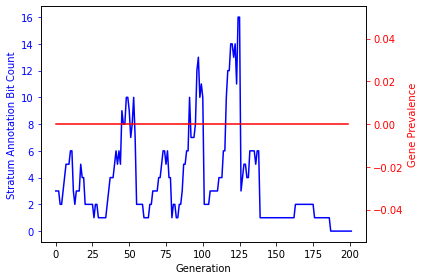

In [10]:
annotations = [
    s.GetAnnotation().bit_count()
    for s in population[0].gene_annotation.IterRetainedStrata()
]


def plot_sweep_and_annotations():
    # Create a figure and a single subplot
    fig, ax1 = plt.subplots()

    # Make the first plot on ax1
    sns.lineplot(data=annotations, color="b", ax=ax1)
    ax1.set_ylabel("Stratum Annotation Bit Count", color="b")
    ax1.tick_params("y", colors="b")

    # Create a second axes that shares the same x-axis
    ax2 = ax1.twinx()

    # Make the second plot on ax2
    sns.lineplot(data=prevalences, color="r", ax=ax2)
    ax2.set_ylabel("Gene Prevalence", color="r")
    ax2.tick_params("y", colors="r")

    ax1.set_xlabel("Generation")

    fig.tight_layout()  # otherwise the right y-label is slightly clipped


tp.tee(
    plot_sweep_and_annotations,
    teeplot_outattrs={
        "notebook": "gene-selection-inference",
        "replicate": str(MILL_REPLICATE),
        "fitness-advantage": str(MILL_FITNESS_ADVANTAGE),
    },
)


In [11]:
records = [
    {
        "notebook": "gene-selection-inference",
        "replicate": MILL_REPLICATE,
        "fitness-advantage": MILL_FITNESS_ADVANTAGE,
        "generation": generation,
        "prevalence": prevalence,
        "annotation": annotation,
    }
    for generation, (prevalence, annotation) in enumerate(
        zip(prevalences, annotations)
    )
]
outdf = pd.DataFrame.from_records(records)
outdf.to_csv(
    kn.pack(
        {
            "a": "prevalence-annotation-by-generation",
            "notebook": "gene-selection-inference",
            "replicate": str(MILL_REPLICATE),
            "fitness-advantage": str(MILL_FITNESS_ADVANTAGE),
            "ext": ".csv",
        }
    )
)
